# Filtragem Baseada em Conteúdo

A filtragem colaborativa depende exclusivamente das interações do usuário-item dentro da matriz de utilidade. O problema com essa abordagem é que novos usuários ou itens sem interações são excluídos do sistema de recomendação. A filtragem baseada em conteúdo é uma maneira de lidar com esse problema, gerando recomendações com base nos recursos do usuário e do item.

In [1]:
# importa os módulos
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# carrega o dataset
df = pd.read_csv('olist_processado.csv')

In [3]:
df.head()

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2
2,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2
3,f0ac8e5a239118859b1734e1087cbb1f,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,251191809e37c1cffc16865947c18a4d,3,-29.879675,-51.272093,moveis_escritorio,1
4,6bc8d08963a135220ed6c6d098831f84,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,f7123bac5b91a0e2e38d8b41fd1206f4,4,-22.610299,-43.176850,moveis_escritorio,1


## Limpeza e exploração de dados


Antes de explorar nosso conjunto de dados de recursos do produto, precisamos limpar de duas maneiras:

Categorias são expressas como uma string com um underline _ separando cada categoria. Vamos manipular essa string em uma lista, o que tornará muito mais fácil de analisar.
Vamos converter isso em uma lista usando a função "split".

Queremos que "moveis_escritorio" se converta em: [moveis, escritorio].

In [4]:
df['product_category_name_split'] = df['product_category_name'].apply(lambda x: x.split('_'))
df.head()

,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,product_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item,product_category_name_split
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,88b8b52d46df026a9d1ad2136a59b30b,4,-20.500253,-47.400367,moveis_escritorio,1,"[moveis, escritorio]"
1,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2,"[moveis, escritorio]"
2,8912fc0c3bbf1e2fbf35819e21706718,santarem,PA,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,7fc63200f12eebb5f387856afdd63db8,1,-2.441535,-54.720801,moveis_escritorio,2,"[moveis, escritorio]"
3,f0ac8e5a239118859b1734e1087cbb1f,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,251191809e37c1cffc16865947c18a4d,3,-29.879675,-51.272093,moveis_escritorio,1,"[moveis, escritorio]"
4,6bc8d08963a135220ed6c6d098831f84,mage,RJ,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,f7123bac5b91a0e2e38d8b41fd1206f4,4,-22.610299,-43.176850,moveis_escritorio,1,"[moveis, escritorio]"


### Quantas categorias temos?
Podemos usar o Contador do Python para criar um dicionário contendo contagens de frequência de cada categoria em nosso conjunto de dados.

In [5]:
from collections import Counter

categoria_counts = Counter(c for categorias in df['product_category_name_split'] for c in categorias)
print(f"Há {len(categoria_counts)} rótulos de categoria.")
categoria_counts

Há 109 rótulos de categoria.


Counter({'moveis': 11375,
         'escritorio': 1726,
         'utilidades': 7131,
         'domesticas': 7131,
         'casa': 1251,
         'conforto': 531,
         'esporte': 8818,
         'lazer': 8785,
         'informatica': 7960,
         'acessorios': 11141,
         'brinquedos': 4182,
         'decoracao': 8680,
         'artes': 243,
         'cama': 11534,
         'mesa': 11534,
         'banho': 11534,
         'automotivo': 4303,
         'climatizacao': 299,
         'telefonia': 4850,
         'beleza': 9810,
         'saude': 9810,
         'ferramentas': 6399,
         'jardim': 5001,
         'pet': 1969,
         'shop': 1969,
         'alimentos': 821,
         'bebes': 3189,
         'construcao': 3431,
         'relogios': 6046,
         'presentes': 6046,
         'cool': 3888,
         'stuff': 3888,
         'sala': 528,
         'cozinha': 305,
         'area': 290,
         'de': 503,
         'servico': 290,
         'jantar': 290,
         'e': 3338,

Existem 109 rótulos de categorias que são usados para descrever os produtos neste conjunto de dados. 

Algumas categorias estão nomeadas com "e", "de", "2", "la". Vamos remover todos essas categorias do dicionário categoria_counts.

In [6]:
deletar = ["e", "de", "2", "la"]

for cat in deletar:
    del categoria_counts[cat]

In [7]:
print("As 20 categorias mais comuns: \n"), categoria_counts.most_common(20)

As 20 categorias mais comuns: 



(None,
 [('cama', 11534),
  ('mesa', 11534),
  ('banho', 11534),
  ('moveis', 11375),
  ('acessorios', 11141),
  ('beleza', 9810),
  ('saude', 9810),
  ('esporte', 8818),
  ('lazer', 8785),
  ('decoracao', 8680),
  ('informatica', 7960),
  ('utilidades', 7131),
  ('domesticas', 7131),
  ('ferramentas', 6399),
  ('relogios', 6046),
  ('presentes', 6046),
  ('jardim', 5001),
  ('telefonia', 4850),
  ('automotivo', 4303),
  ('brinquedos', 4182)])

In [8]:
categoria_count_df = pd.DataFrame([categoria_counts]).T.reset_index()

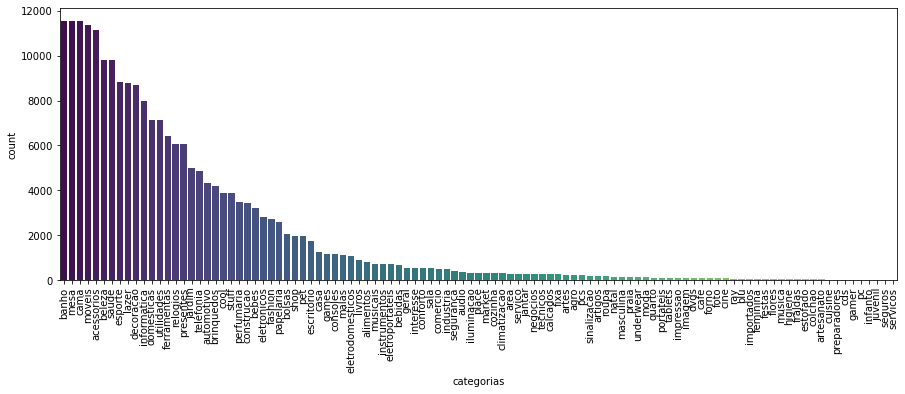

In [9]:
categoria_count_df.columns = ['categorias', 'count']
categoria_count_df = categoria_count_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x='categorias', y='count', data=categoria_count_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

O gráfico acima mostra que as categorias, Banho, Mesa, Cama, Móveis e Acessórios são os produtos mais populares. E os menos populares são Seguros e Serviços.

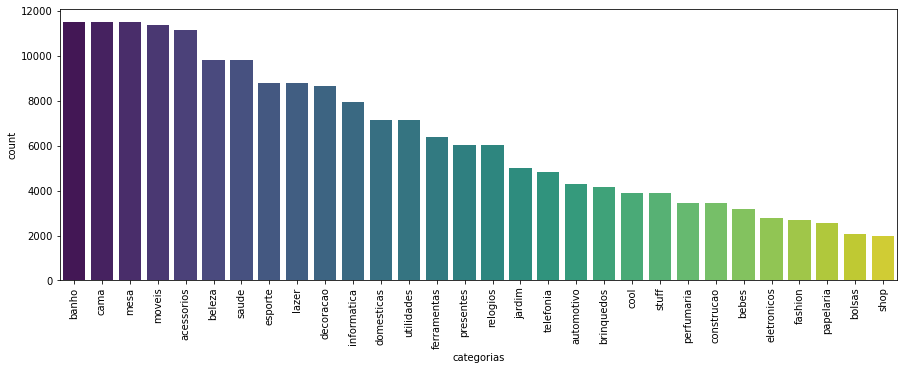

In [10]:
categoria_count_df.columns = ['categorias', 'count']
categoria_count_df = categoria_count_df.sort_values(by='count', ascending=False)
categoria_count_df = categoria_count_df.nlargest(30, 'count')

plt.figure(figsize=(15,5))
sns.barplot(x='categorias', y='count', data=categoria_count_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

### Como é o fluxo de compras anual?
Algumas perguntas como:
- qual o mês que um produto específico é comprado? 
- Qual horário geralmente as pessoas compram? 
Podem ser importantes para saber o momento ideal de recomendar o produto para algum consumidor.

A coluna com as informações da data das compras foi divida em ano, mês e hora, para analisarmos os períodos de compras.

In [11]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['ano'], df['mes'], df['dia'], df['hora']  = df['order_purchase_timestamp'].apply(lambda x: x.year), df['order_purchase_timestamp'].apply(lambda x: x.month), df['order_purchase_timestamp'].apply(lambda x: x.day), df['order_purchase_timestamp'].apply(lambda x: x.hour) 

Como vimos na separação de categorias, percebemos que a Categoria "Cama, Mesa e Banho" é a mais popular, por isso, um filtro foi criado criando um dataframe apenas com essa categoria.

In [12]:
prod_categoria = df.query('product_category_name == "cama_mesa_banho"')

Qual o produto dessa categoria foi o mais comprado?

In [13]:
prod= prod_categoria.groupby(['product_id']).count().reset_index()
prod = prod.sort_values(by='customer_id', ascending=False)
prod = prod.nlargest(5, 'customer_id')
prod

,product_id,customer_id,customer_city,customer_state,order_id,order_purchase_timestamp,order_item_id,price,review_id,review_score,customer_lat,customer_long,product_category_name,quantidade_item,product_category_name_split,ano,mes,dia,hora
1959,99a4788cb24856965c36a24e339b6058,491,491,491,491,491,491,491,491,491,491,491,491,491,491,491,491,491,491
3042,f1c7f353075ce59d8a6f3cf58f419c9c,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155,155
81,06edb72f1e0c64b14c5b79353f7abea3,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
2972,ec2d43cc59763ec91694573b31f1c29a,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131,131
1687,84f456958365164420cfc80fbe4c7fab,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111


Ao filtrar o produto mais comprado, podemos visualizar o comportamento de compra do mesmo ao longo dos meses.

In [14]:
prod_id_geral = df.query('product_id == "99a4788cb24856965c36a24e339b6058"')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

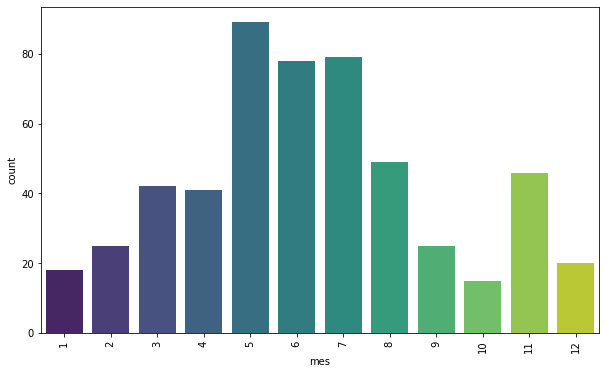

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(prod_id_geral['mes'], palette='viridis')
plt.xticks(rotation=90)

**O produto específico foi mais comprado nos períodos de Outono/Inverno.**

### Quantos produtos diferentes tem no dataset?

In [16]:
df['product_id'].nunique()

32400

In [17]:
df = df[~df['price'].isnull()]
print(f"Número de produtos após a remoção dos preços nulos: {df['product_id'].nunique()}")

Número de produtos após a remoção dos preços nulos: 32400


### Arredondar os preços para ficar mais fácil a visualização dos valores no gráfico

In [18]:
x = 124.99

def round_down(preco):
    return preco - (preco%100)

round_down(x)

100.0

In [19]:
df['preco_arredondado'] = df['price'].apply(round_down)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '100.0'),
  Text(2, 0, '200.0'),
  Text(3, 0, '300.0'),
  Text(4, 0, '400.0'),
  Text(5, 0, '500.0'),
  Text(6, 0, '600.0'),
  Text(7, 0, '700.0'),
  Text(8, 0, '800.0'),
  Text(9, 0, '900.0'),
  Text(10, 0, '1000.0'),
  Text(11, 0, '1100.0'),
  Text(12, 0, '1200.0'),
  Text(13, 0, '1300.0'),
  Text(14, 0, '1400.0'),
  Text(15, 0, '1500.0'),
  Text(16, 0, '1600.0'),
  Text(17, 0, '1700.0'),
  Text(18, 0, '1800.0'),
  Text(19, 0, '1900.0'),
  Text(20, 0, '2000.0'),
  Text(21, 0, '2100.0'),
  Text(22, 0, '2200.0'),
  Text(23, 0, '2300.0'),
  Text(24, 0, '2400.0'),
  Text(25, 0, '2500.0'),
  Text(26, 0, '2600.0'),
  Text(27, 0, '2700.0'),
  Text(28, 0, '2800.0'),
  Text(29, 0, '2900.0'),
  Text(30, 0, '3000.0'),
  Text(31, 0, '3100.0'),
  Text(32, 0, '3

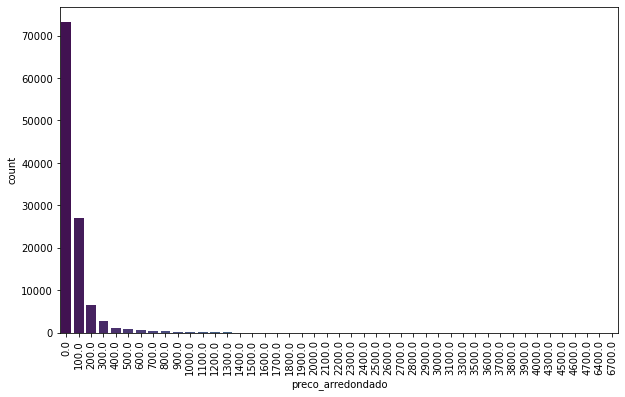

In [20]:
plt.figure(figsize=(10,6))
sns.countplot(df['preco_arredondado'], palette='viridis')
plt.xticks(rotation=90)

In [21]:
df_preco = df.loc[(df["preco_arredondado"] >= 0) & (df["preco_arredondado"] < 1000)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '100.0'),
  Text(2, 0, '200.0'),
  Text(3, 0, '300.0'),
  Text(4, 0, '400.0'),
  Text(5, 0, '500.0'),
  Text(6, 0, '600.0'),
  Text(7, 0, '700.0'),
  Text(8, 0, '800.0'),
  Text(9, 0, '900.0')])

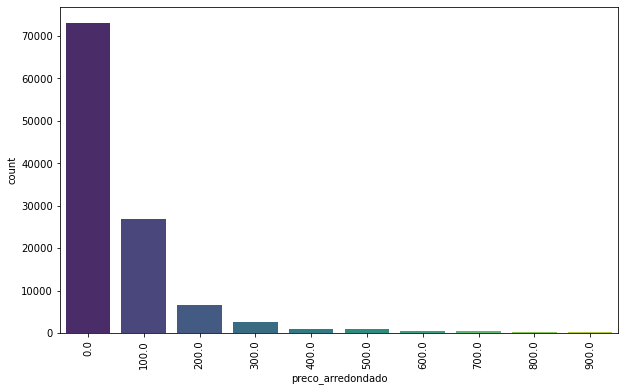

In [22]:
plt.figure(figsize=(10,6))
sns.countplot(df_preco['preco_arredondado'], palette='viridis')
plt.xticks(rotation=90)

Podemos ver no gráfico acima que a maioria dos produtos estão entre os valores de 0 a 100 reais (Cerca de 70 mil compras estão nesse valor)

## Transformar os dados
Para construir um recomendador de filtragem baseado em conteúdo, precisamos configurar nosso conjunto de dados para que as linhas representem produtos e as colunas representem recursos (ou seja, categoria e preço).

Primeiro, precisamos manipular a coluna de categorias para que cada categoria seja representado como um recurso binário separado. "1" indica que o produto se enquadra em um determinado categoria, enquanto "0" não.

In [23]:
categorias = list(categoria_counts.keys())

for c in categorias:
    df[c] = df['product_category_name'].transform(lambda x: int(c in x))

df[categorias].head()

,moveis,escritorio,utilidades,domesticas,casa,conforto,esporte,lazer,informatica,acessorios,...,fraldas,higiene,cine,foto,infanto,juvenil,cds,artesanato,seguros,servicos
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Nossas colunas de categorias são representadas como recursos binários. O próximo passo é transformar nossa coluna de preço arredondado para que cada preço tenha sua própria coluna. Podemos fazer isso usando a função get_dummies () do pandas, que funciona criando uma variável categórica em variáveis binárias.

In [24]:
categoria_preco_arredondado = pd.get_dummies(df['preco_arredondado'])
categoria_preco_arredondado.head()

,0.0,100.0,200.0,300.0,400.0,500.0,600.0,700.0,800.0,900.0,...,3700.0,3800.0,3900.0,4000.0,4300.0,4500.0,4600.0,4700.0,6400.0,6700.0
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Agora, vamos criar um novo dataframe categoria_features combinando nossos recursos de categoria e recursos de preço. Podemos fazer isso usando a função concat do pandas, que concatena (acrescenta) categorias e preço_arredondado em um único dataframe.

In [25]:
categoria_features = pd.concat([df[categorias], categoria_preco_arredondado], axis=1)
categoria_features

,moveis,escritorio,utilidades,domesticas,casa,conforto,esporte,lazer,informatica,acessorios,...,3700.0,3800.0,3900.0,4000.0,4300.0,4500.0,4600.0,4700.0,6400.0,6700.0
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113617,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113620,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


O novo dataframe foi criado. A próxima etapa é começar a construir o Sistema de Recomendação.

Como nosso dataset contém muitas linhas(113622), fica inviável fazer uma matriz utilizando todas elas, portanto foi criada uma amostra simples aleatória utilizando n = 20000

In [26]:
categoria_features_sample = categoria_features.sample(n=20000)

## Etapa 5: Construindo um Recomendador de "Produtos Similares" Usando Cosine Similarity

Vamos construir nosso recomendador item-item usando uma métrica de similaridade chamada similaridade de cosseno.

A similaridade de cosseno olha para o ângulo de cosseno entre dois vetores (por exemplo, **A** e **B**). Quanto menor o ângulo do cosseno, maior o grau de similaridade entre **A** e **B**. 

Usaremos a função de similaridade de cosseno de scikit-learn para gerar uma matriz de similaridade de cosseno de forma (n_product X n_product). Com essa matriz de similaridade de cosseno, poderemos extrair produtos que sejam mais semelhantes ao produto de interesse.

In [27]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_sim = cosine_similarity(categoria_features_sample, categoria_features_sample)
print(f"Dimensão da matriz cosine de similaridade: {cosine_sim.shape}")

Dimensão da matriz cosine de similaridade: (20000, 20000)


Como esperado, depois de passar o dataframe categoria_features_sample para a função cosine_similarity (), obtemos uma matriz de similaridade de cosseno da forma $(n_product X n_product).

Essa matriz é preenchida com valores entre 0 e 1, que representam o grau de similaridade entre os produtos ao longo dos eixos x e y.

In [28]:
print(cosine_sim)

[[1.         0.5        0.         ... 0.         0.40824829 0.40824829]
 [0.5        1.         0.         ... 0.         0.40824829 0.40824829]
 [0.         0.         1.         ... 0.33333333 0.         0.        ]
 ...
 [0.         0.         0.33333333 ... 1.         0.         0.        ]
 [0.40824829 0.40824829 0.         ... 0.         1.         0.33333333]
 [0.40824829 0.40824829 0.         ... 0.         0.33333333 1.        ]]


## Vamos criar uma função de localização de Produtos

Digamos que desejamos obter recomendações de produtos semelhantes ao produto '9391a573abe00141c56e38d84d7d5b3b'. Para obter resultados de nosso recomendador, precisamos saber o título exato do produto em nosso conjunto de dados.

Em nosso conjunto de dados, '9391a573abe00141c56e38d84d7d5b3b' está listado como '9391a573abe00141c56e38d84d7d5b3b'. Se escrevermos '9391a573abe00141c56e38d84d7d5b3b' incorretamente, nosso recomendador não será capaz de identificar em qual produto estamos interessados.

Para tornar nosso recomendador mais amigável, podemos usar um pacote Python chamado fuzzywuzzy que encontrará o produto mais semelhante a uma string que você passar. Vamos criar uma função chamada busca_produto() que aproveita o algoritmo de correspondência de string de fuzzywuzzy para obter o título mais semelhante a uma string inserida pelo usuário.

In [29]:
from fuzzywuzzy import process

def busca_produto(produto):
    todos_produtos = df['product_id'].tolist()
    match_proximo = process.extractOne(produto, todos_produtos)
    return match_proximo[0]

/home/ariana/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Vamos testar isso com nosso exemplo '9391a573abe00141c56e38d84d7d5b3b' sem os últimos 3 caracteres

In [30]:
produto = busca_produto('9391a573abe00141c56e38d84d7d5')
produto

'9391a573abe00141c56e38d84d7d5b3b'

Para obter recomendações relevantes para o produto '9391a573abe00141c56e38d84d7d5', precisamos encontrar seu índice na matriz de simialidade de cosseno. Para identificar qual linha devemos examinar, podemos criar um mapeador de índice de produto que mapeia um título do produto para o índice que ele representa em nossa matriz.

Vamos criar um dicionário de índice de produtos chamado produto_idx, onde as chaves são os títulos os id's do produto e os valores são os índices dos produtos:

In [31]:
produto_idx = dict(zip(df['product_id'].unique(), list(df.index)))
idx = produto_idx[produto]
idx

6

Usando este prático dicionário produto_idx, sabemos que '99a4788cb24856965c36a24e339b6058' é representado pelo índice **25** em nossa matriz. Vamos pegar os 10 produtos mais semelhantes dele.

In [32]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_produto = [i[0] for i in sim_scores]


In [33]:
similar_produto

[351, 390, 629, 646, 1271, 1304, 1754, 1789, 1916, 1993]

similar_produtos é um conjunto de índices que representa as 10 principais recomendações de '99a4788cb24856965c36a24e339b6058'. Podemos obter os id's dos produtos correspondentes criando um mapeador produto_idx inverso ou usando iloc na coluna do product_id.

In [34]:
print(f"Porque você comprou {produto}:")
produto_recomendado = df[['product_id', 'product_category_name']].iloc[similar_produto]
produto_recomendado.drop_duplicates(subset='product_id', keep='first')

Porque você comprou 9391a573abe00141c56e38d84d7d5b3b:


,product_id,product_category_name
351,e64e4ef7b809314306d9c09635d8cd30,pet_shop
390,99a4788cb24856965c36a24e339b6058,cama_mesa_banho
1271,368c6c730842d78016ad823897a372db,ferramentas_jardim
1754,2028bf1b01cafb2d2b1901fca4083222,perfumaria
1789,f89caa3ea4fb5f7b6e7fb2bb4ba61881,cama_mesa_banho
1916,422879e10f46682990de24d770e7f83d,ferramentas_jardim


***Podemos testar nosso recomendador ainda mais com outros produtos, utilizando a função que inclui o produto de interesse e o número de recomendações.***

In [35]:
def get_content_based_recommendations(produto_string, n_recommendations=10):
    produto = busca_produto(produto_string)
    idx = produto_idx[produto]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_produto = [i[0] for i in sim_scores]
    print(f"Porque você comprou {produto}:")
    df[['product_id', 'product_category_name']].iloc[similar_produto]
    print(produto_recomendado.drop_duplicates(subset='product_id', keep='first'))

In [36]:
get_content_based_recommendations('f6fe3b4ddecd4a8393c6a1385de3bfb6', 10)

Porque você comprou d6fe3b4ddecd4a8393c6a1385de3bfb6:
                            product_id product_category_name
351   e64e4ef7b809314306d9c09635d8cd30              pet_shop
390   99a4788cb24856965c36a24e339b6058       cama_mesa_banho
1271  368c6c730842d78016ad823897a372db    ferramentas_jardim
1754  2028bf1b01cafb2d2b1901fca4083222            perfumaria
1789  f89caa3ea4fb5f7b6e7fb2bb4ba61881       cama_mesa_banho
1916  422879e10f46682990de24d770e7f83d    ferramentas_jardim
